# Installing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
plt.style.use('fivethirtyeight')

# Loading Data

In [2]:
data=sm.datasets.co2.load_pandas()

In [3]:
co2=data.data

In [4]:
co2.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


### Checking index is date

In [5]:
co2.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

Since the data is daily data, we need to resample it monthly

### Resampling

In [7]:
y=co2['co2'].resample('MS').mean()

In [8]:
type(y)

pandas.core.series.Series

In [9]:
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

## Cleaning NULLS

In [10]:
y.isnull().sum()

5

In [11]:
y=y.fillna(y.bfill())

In [12]:
y.isnull().sum()

0

In [13]:
y.shape

(526,)

## Plotting the time series

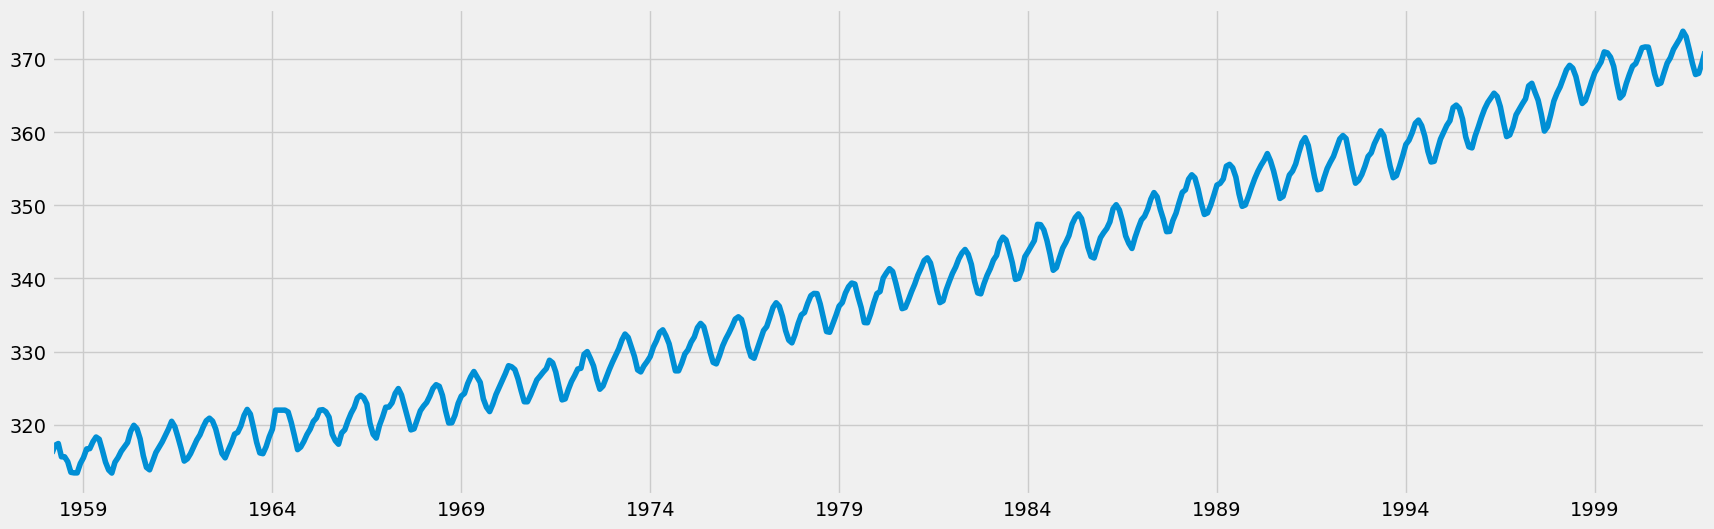

In [14]:
y.plot(figsize=(19,6))
plt.show();

Observations:

1. The time-series has seasonality pattern.
2. There is an upward trend.

## Stationarity Check

We will try the following to ensure stationarity of the series:

1. Time series decomposition
2. ADF test

### Time series decomposition

In [15]:
from pylab import rcParams
rcParams['figure.figsize']=19,9

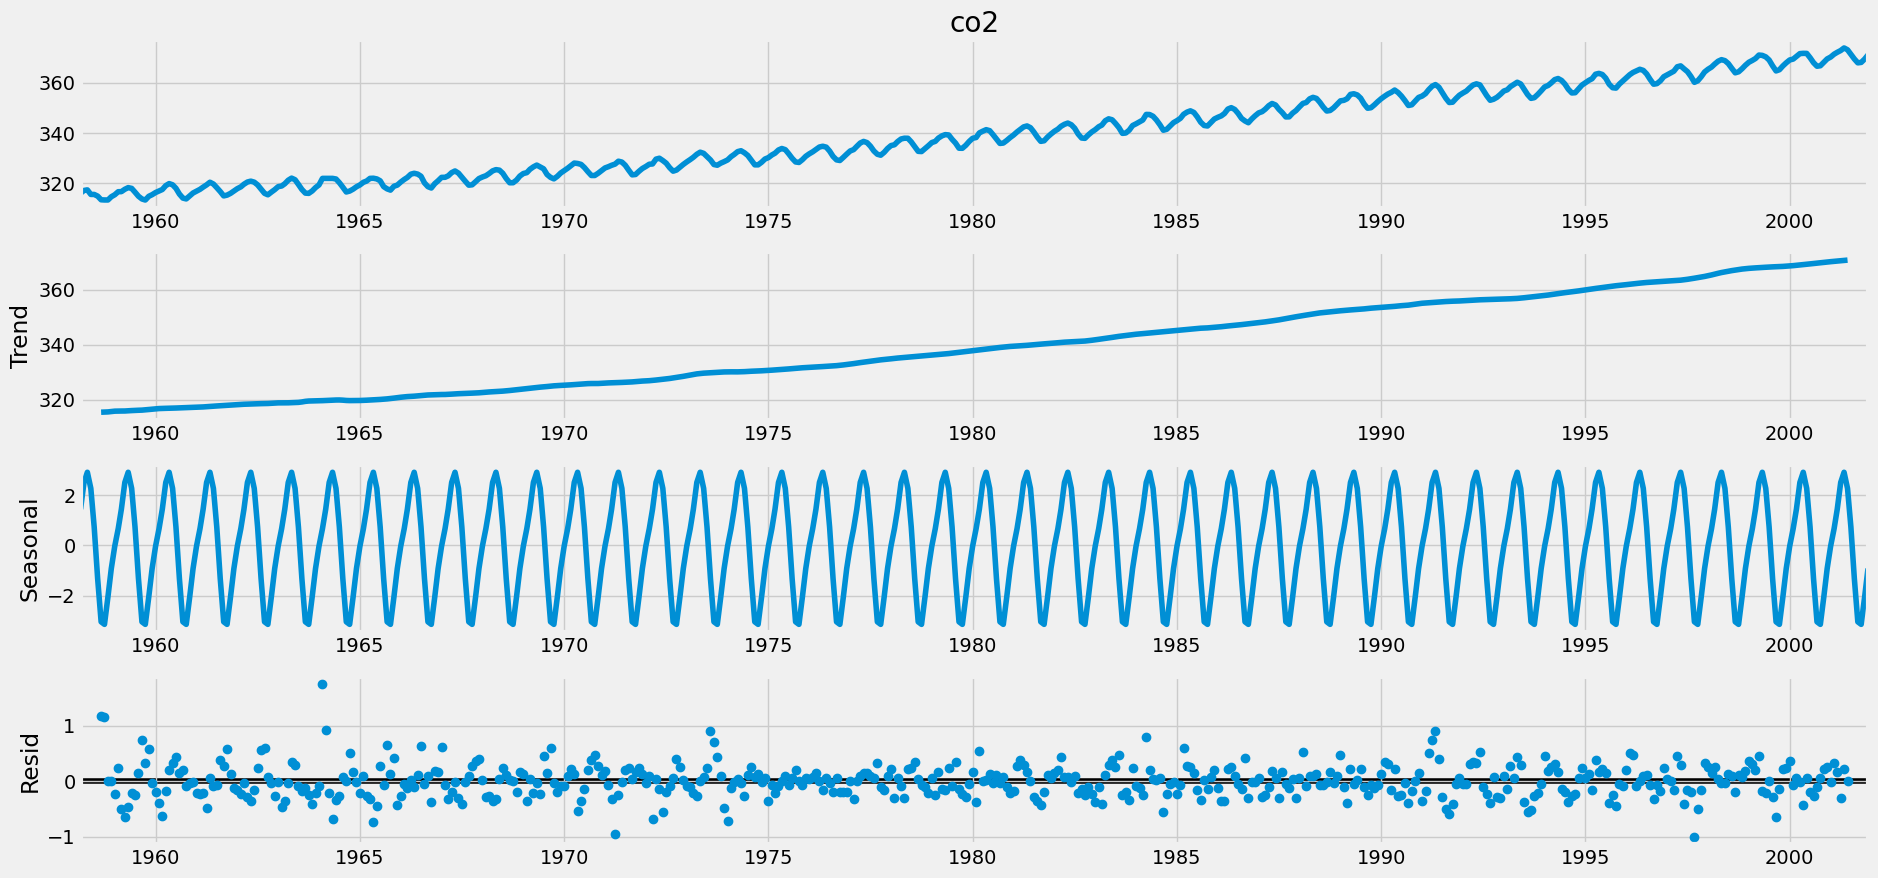

In [16]:
decomposition=sm.tsa.seasonal_decompose(y,model='additive')
fig=decomposition.plot()
plt.show();

We clearly see the sinosudial seasonality and upward trend, lets move on to ADF test

### ADF Test

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
# This fuction computes ADF test statistic for input time series
def test_adfuller(data):
    res=adfuller(data)
    labels=['ADF Test Statistic','p-value','#Lags Used','No. of obs. used']
    for label, value in zip(labels,res):
        print(label+':'+str(value))
    if res[1]<=0.05:
        print('H0 is rejected, series is stationary')
    else:
        print('Failed to reject H0, series is not stationary')

In [19]:
test_adfuller(y)

ADF Test Statistic:2.359809953995351
p-value:0.9989901230798025
#Lags Used:14
No. of obs. used:511
Failed to reject H0, series is not stationary


**Observation:**
    
1. **From visual inspection of the time series decomposition, there seems to be a clear upward trend coupled with a 12 months seasonality.**
2. **This is further validated by the augmented dicky fuller test.**

## Trying differencing

Lets see if differencing the series could make the series stationary

In [22]:
ydf=pd.DataFrame(y)

In [23]:
ydf.head()

,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,315.625000
1958-07-01,315.625000


In [24]:
ydf['First difference']=ydf['co2']-ydf['co2'].shift(1)

In [25]:
ydf['First seasonal difference']=ydf['First difference']-ydf['First difference'].shift(12)

In [26]:
test_adfuller(ydf['First difference'].dropna())

ADF Test Statistic:-5.063202630318517
p-value:1.661485131768491e-05
#Lags Used:13
No. of obs. used:511
H0 is rejected, series is stationary


In [27]:
test_adfuller(ydf['First seasonal difference'].dropna())

ADF Test Statistic:-8.72489160152173
p-value:3.3089937777514864e-14
#Lags Used:15
No. of obs. used:497
H0 is rejected, series is stationary


<AxesSubplot:>

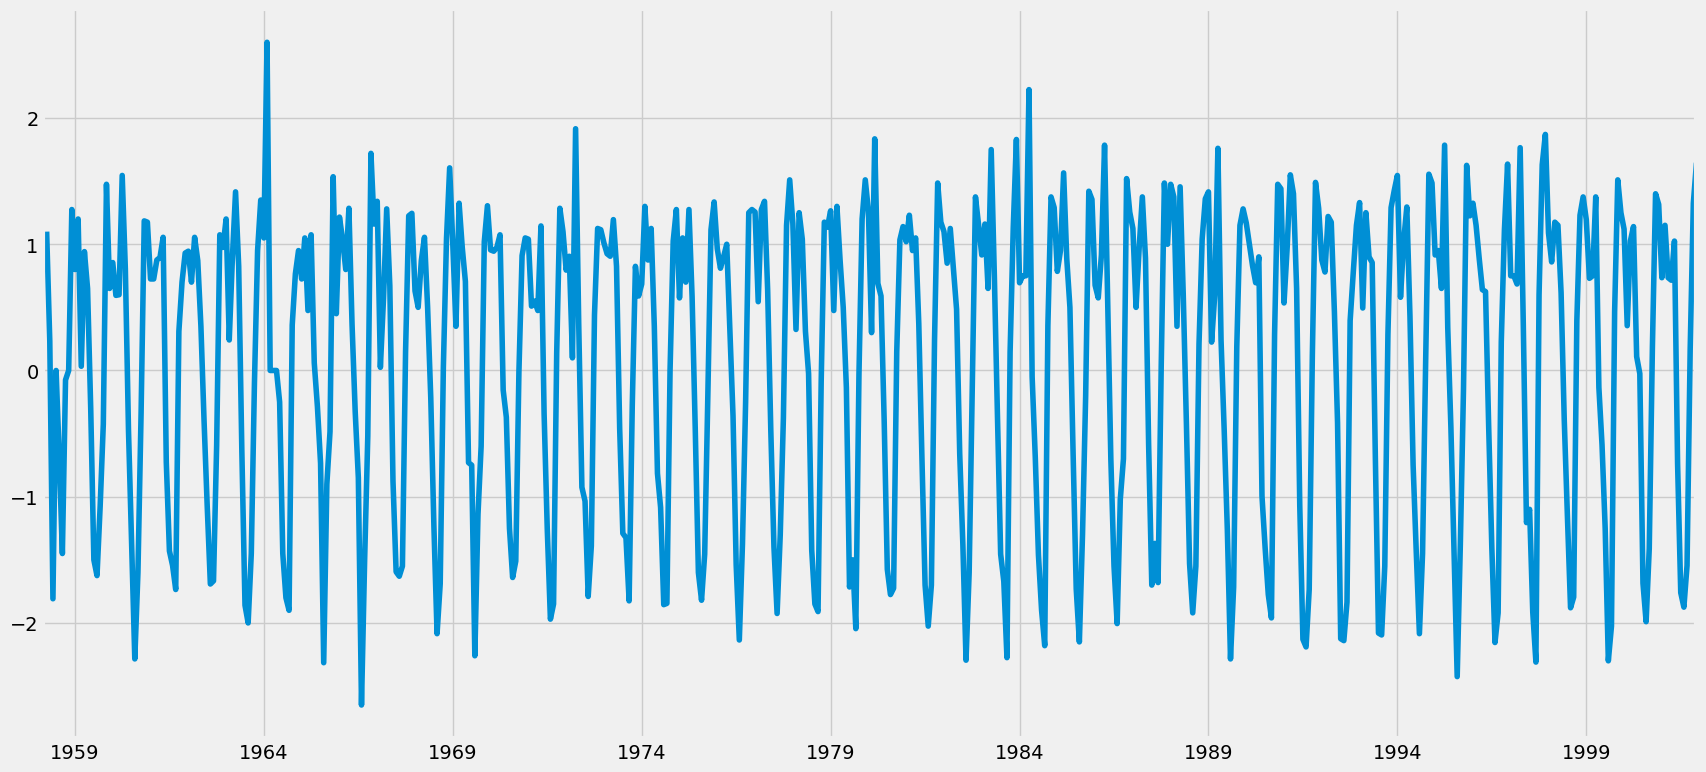

In [30]:
ydf['First difference'].plot()

<AxesSubplot:>

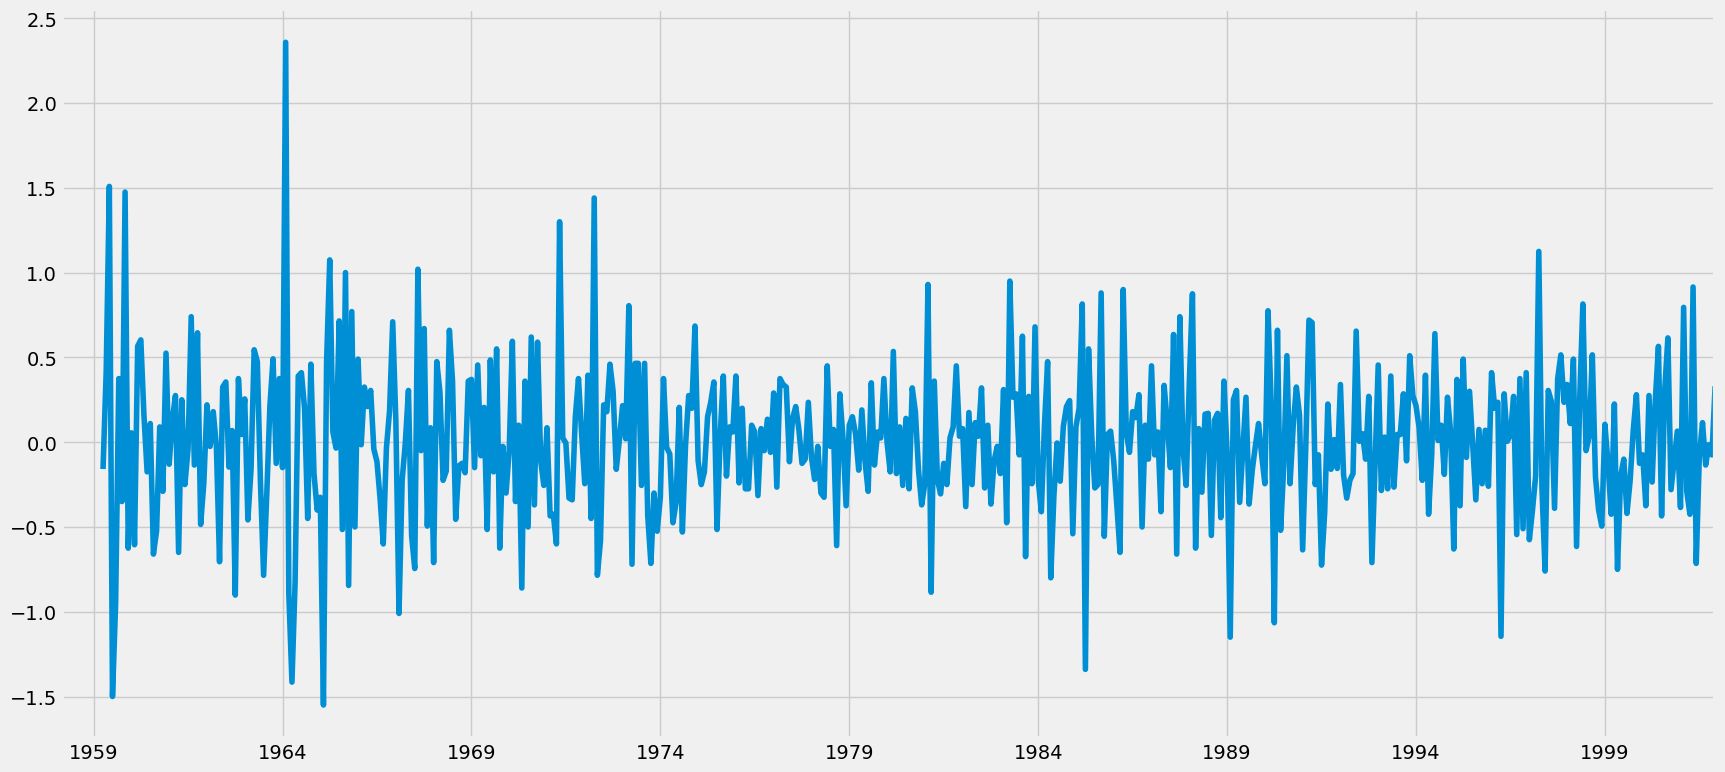

In [31]:
ydf['First seasonal difference'].plot()

OBSERVATIONS:
    
1. It seems that differencing once removes the trend.
2. Seasonal differencing with 12 months period once removes the seasonality.

## ACF and PACF plots

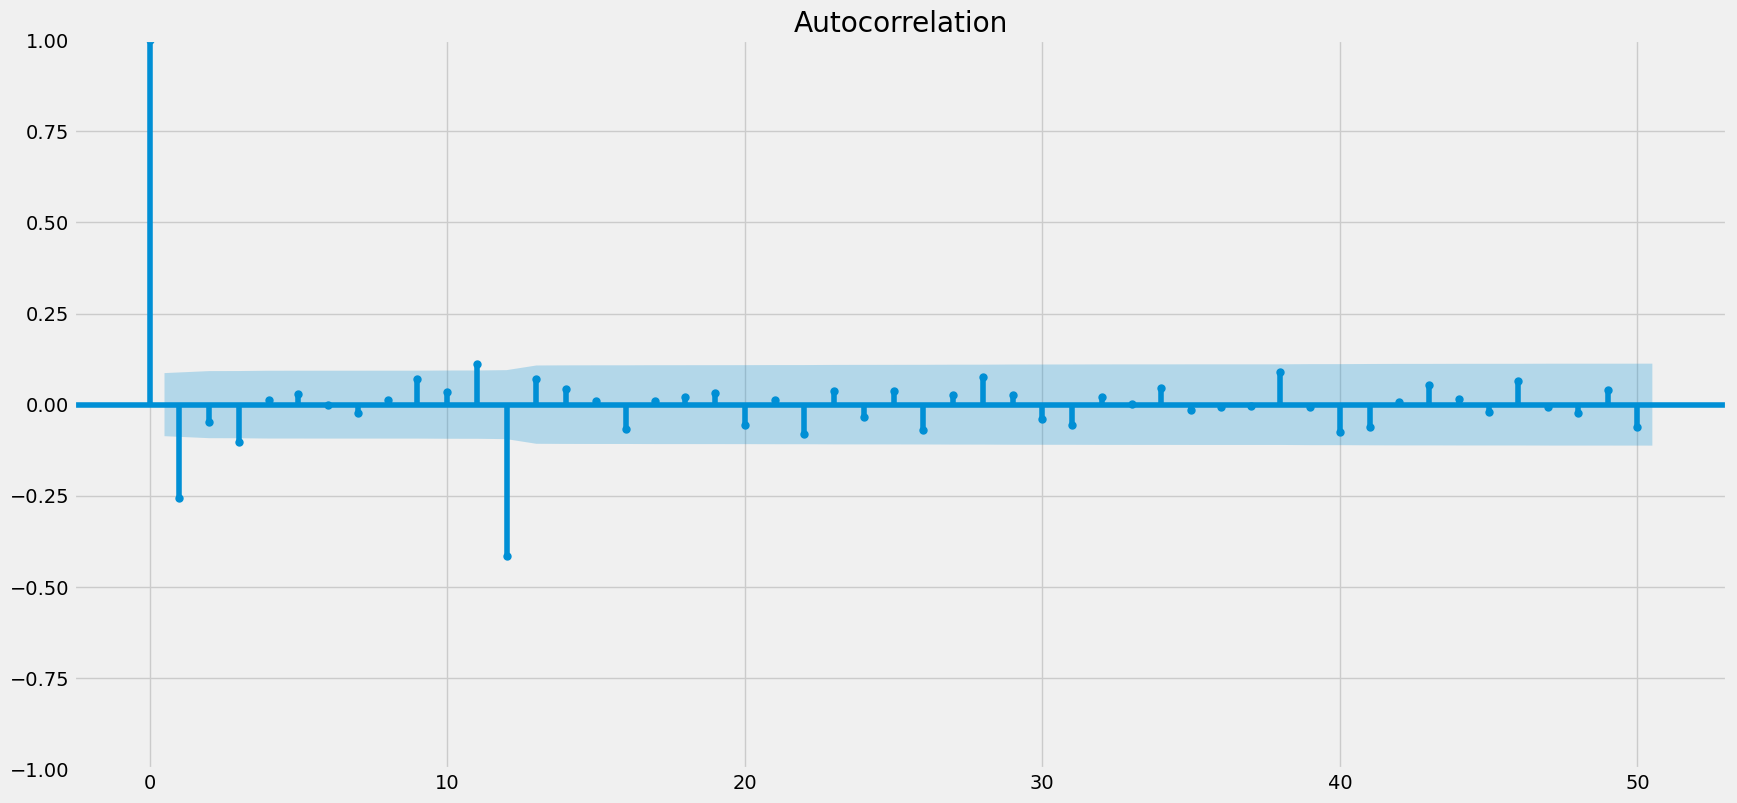

In [34]:
sm.graphics.tsa.plot_acf(ydf['First seasonal difference'].iloc[13:],lags=50);

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


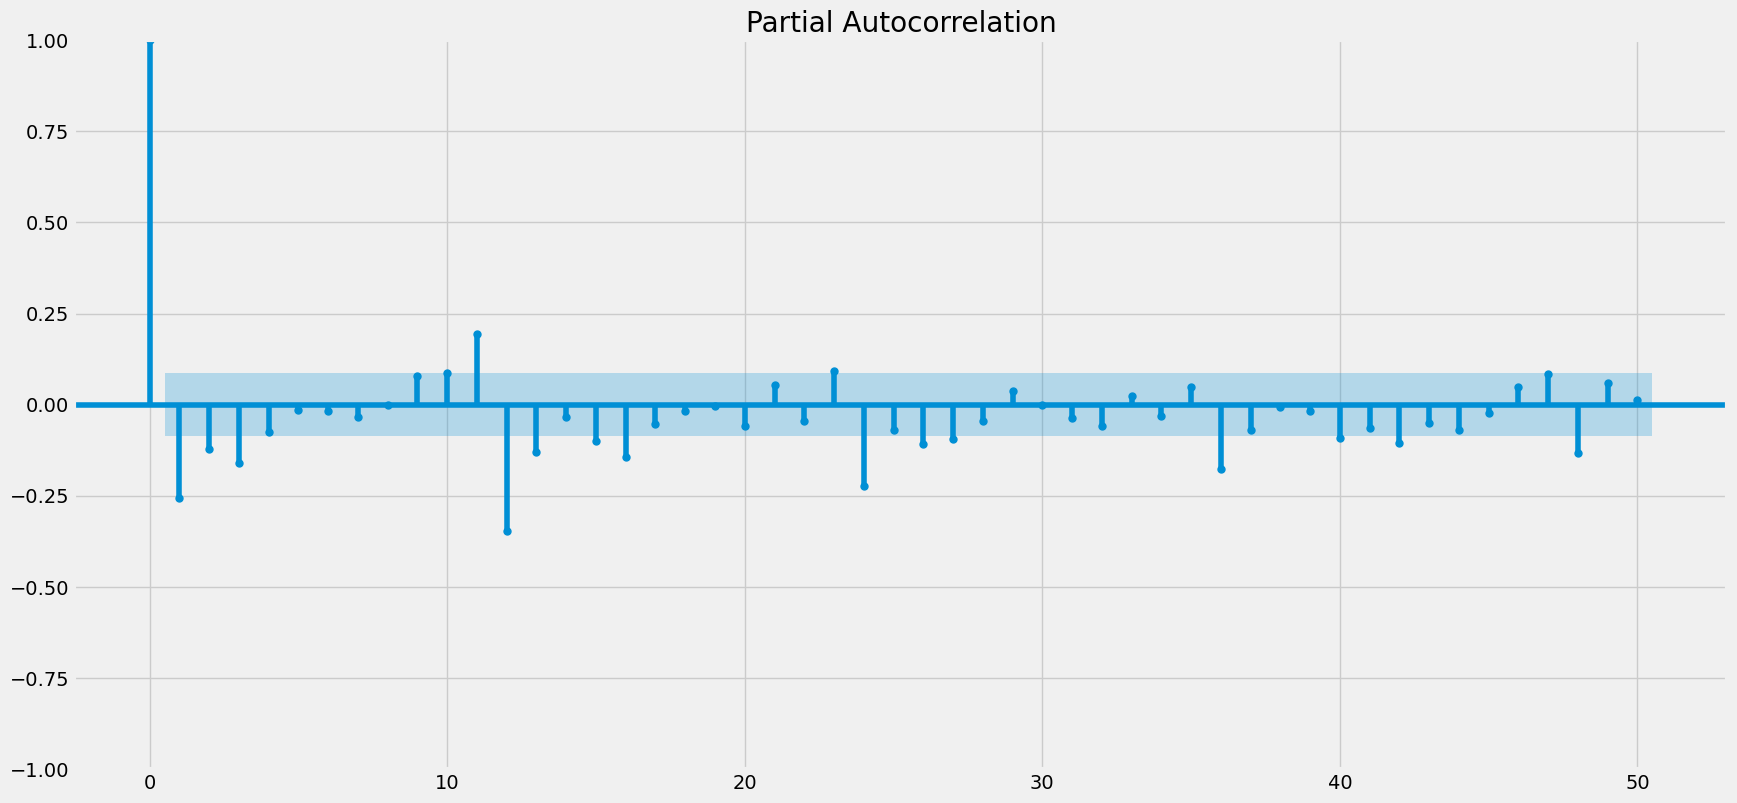

In [35]:
sm.graphics.tsa.plot_pacf(ydf['First seasonal difference'].iloc[13:],lags=50);

## Implementing Sarimax

### Using grid search

Although we have an intution via differencing, acf and pacf plots for parameters of Sarimax, Nonetheless lets try to use grid search to confirm or revise out initial guess.

In [37]:
#genereating triplets
p=d=q=range(0,2)

In [38]:
l=[]
n=[]
for i in p:
    for j in d:
        for k in q:
            m=[]
            o=[]
            m.append(i)
            m.append(j)
            m.append(k)
            l.append(m)
            o.append(i)
            o.append(j)
            o.append(k)            
            o.append(12)
            n.append(o)

## Train test split

In [44]:
train=y[:-52]
test=y[-52:]

### Using AIC to select best parameters

In [45]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
bb=[]
for param in l:
    for param_seasonal in n:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            t=[]
            t.append(param)
            t.append(param_seasonal)
            t.append(results.aic)
            bb.append(t)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA[0, 0, 0]x[0, 0, 0, 12]12 - AIC:6849.7238119731965
ARIMA[0, 0, 0]x[0, 0, 1, 12]12 - AIC:6095.2028671864055
ARIMA[0, 0, 0]x[0, 1, 0, 12]12 - AIC:1627.1323939921454
ARIMA[0, 0, 0]x[0, 1, 1, 12]12 - AIC:1380.169485221506
ARIMA[0, 0, 0]x[1, 0, 0, 12]12 - AIC:908.110764872803
ARIMA[0, 0, 0]x[1, 0, 1, 12]12 - AIC:907.8031687453179
ARIMA[0, 0, 0]x[1, 1, 0, 12]12 - AIC:1161.3871367167858
ARIMA[0, 0, 0]x[1, 1, 1, 12]12 - AIC:902.6278659627242
ARIMA[0, 0, 1]x[0, 0, 0, 12]12 - AIC:6190.13830777309
ARIMA[0, 0, 1]x[0, 0, 1, 12]12 - AIC:5452.469957551746
ARIMA[0, 0, 1]x[0, 1, 0, 12]12 - AIC:1215.0737709764662
ARIMA[0, 0, 1]x[0, 1, 1, 12]12 - AIC:1083.259419676565
ARIMA[0, 0, 1]x[1, 0, 0, 12]12 - AIC:927.3926592171721
ARIMA[0, 0, 1]x[1, 0, 1, 12]12 - AIC:683.0043837784256
ARIMA[0, 0, 1]x[1, 1, 0, 12]12 - AIC:971.8616218288616
ARIMA[0, 0, 1]x[1, 1, 1, 12]12 - AIC:709.4682240753411
ARIMA[0, 1, 0]x[0, 0, 0, 12]12 - AIC:1503.7636974779816
ARIMA[0, 1, 0]x[0, 0, 1, 12]12 - AIC:1110.244856231258
ARIMA[

#### We see that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 255.79.

### Initializing best parameters

In [46]:
mod=sm.tsa.statespace.SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12),enforce_stationarity=False,enforce_invertibility=False)

In [47]:
results=mod.fit()

In [48]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3634,0.089,4.095,0.000,0.189,0.537
ma.L1,-0.6832,0.069,-9.886,0.000,-0.819,-0.548
ar.S.L12,0.0010,0.001,1.706,0.088,-0.000,0.002
ma.S.L12,-1.1415,0.036,-31.712,0.000,-1.212,-1.071
sigma2,0.0753,0.005,14.763,0.000,0.065,0.085


## Checking Model Diagnostics

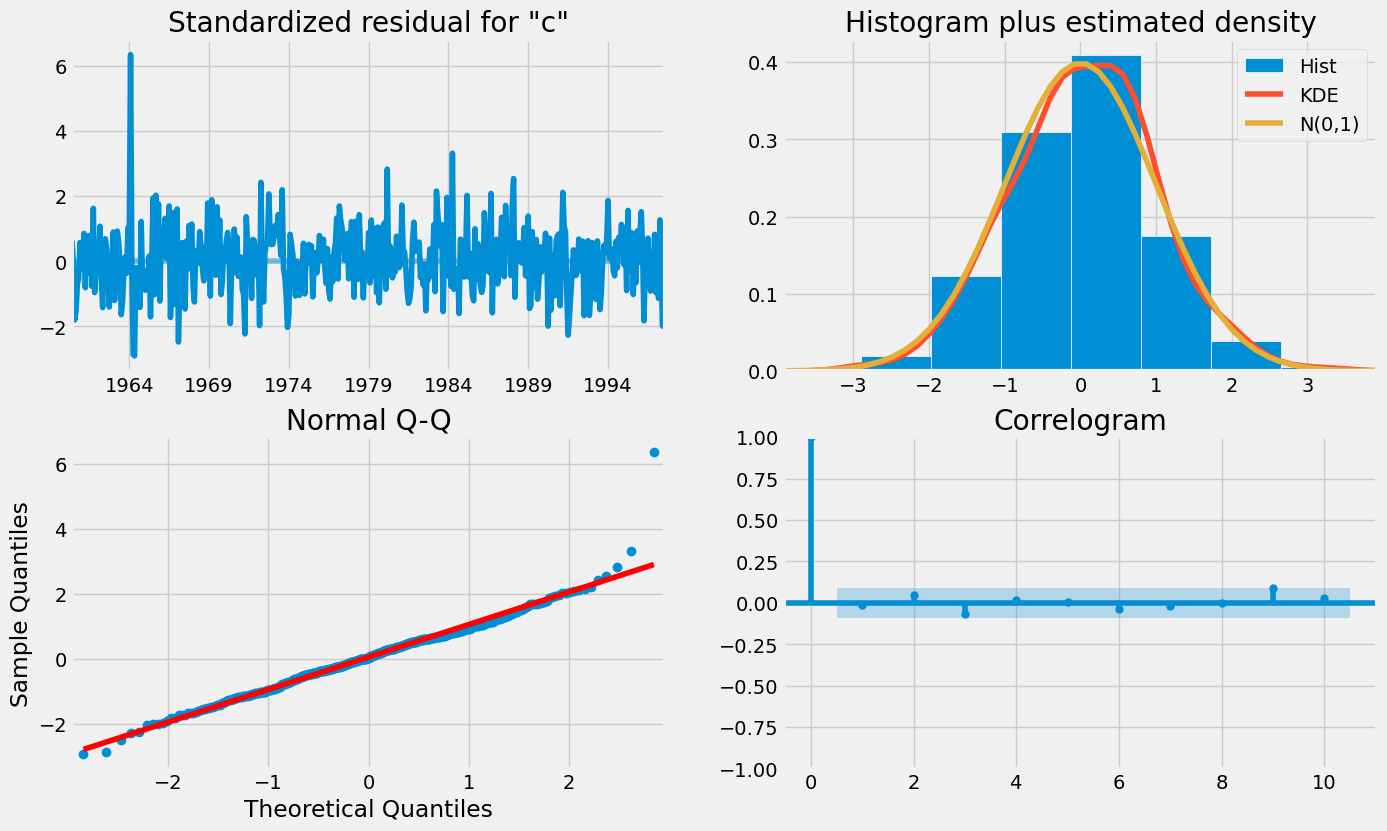

In [49]:
results.plot_diagnostics(figsize=(15,9))
plt.show()

Observations:

1. Residuals of our model are uncorrelated and normally distributed with zero-mean.

- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution.

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

- The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## Model Validation

In [50]:
pred=results.get_forecast(steps=52)
pred_ci=pred.conf_int()

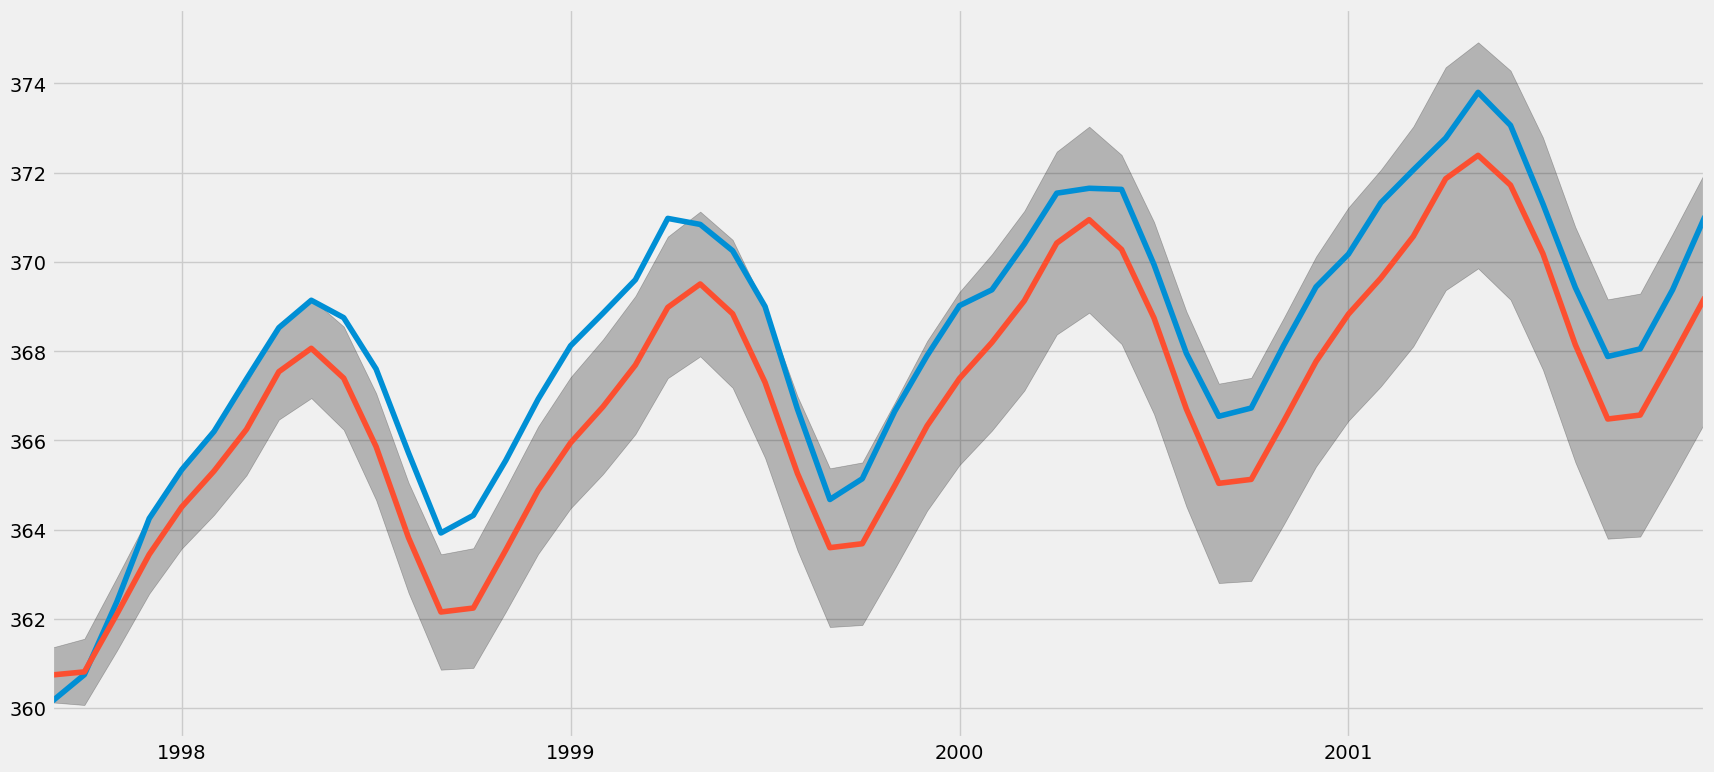

In [51]:
ax=test.plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='Predicted')
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='k',alpha=.25)

Conclusion: We see that our results are well within the confidence interval.

## MSE Calculation

In [52]:
test_forecast=pred.predicted_mean
mse_forecast=((test-test_forecast)**2).mean()
mse_forecast

2.133622970958876

# Future forecasts

In [54]:
mod_final=sm.tsa.statespace.SARIMAX(y,order=(1,1,1),seasonal_order=(1,1,1,12),enforce_stationarity=False,enforce_invertibility=False)

In [55]:
results_f=mod_final.fit()

In [56]:
pred_f=results_f.get_forecast(steps=500)

In [57]:
pred_f_ci=pred_f.conf_int()

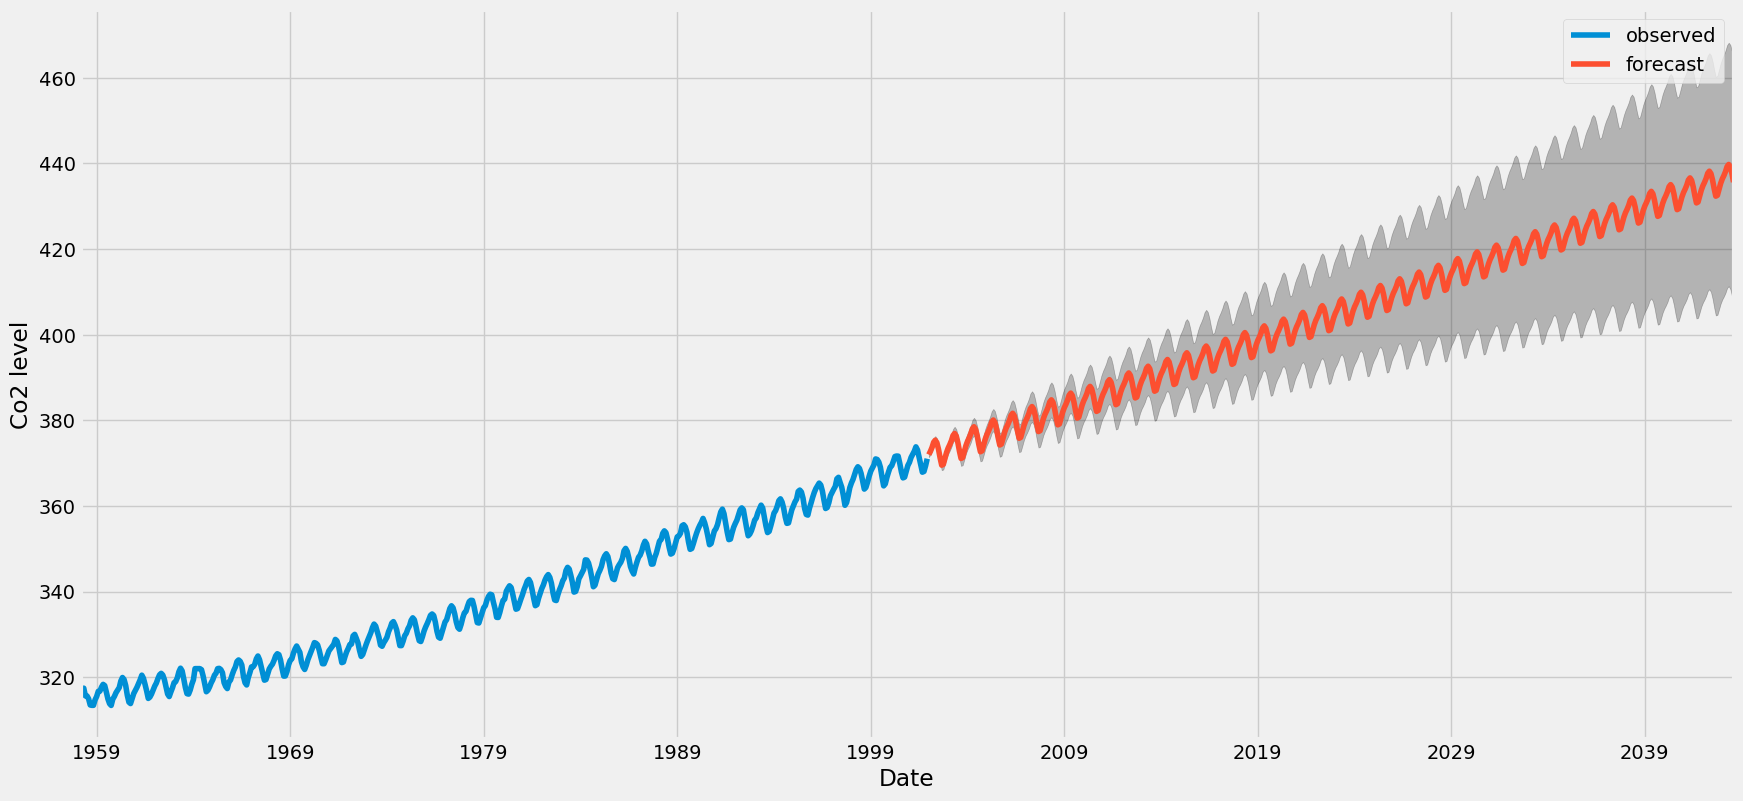

In [58]:
ax=y.plot(label='observed')
pred_f.predicted_mean.plot(ax=ax,label='forecast')
ax.fill_between(pred_f_ci.index,pred_f_ci.iloc[:,0],pred_f_ci.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Co2 level')
plt.legend()
plt.show();

In [61]:
y_f=pred_f.predicted_mean

## Conclusion: y_f contains the forecasts for next 500 months